# Skin cancer classification challenge

**Summary :** Skin cancer classification

## Preliminaries and Imports

In [1]:
import json
import collections
from PIL import Image
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 10  #default setting
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

## I. Load metadata

- **Rq : ** Datasets are quite light, can be fully loaded in a laptop memory with ease.

In [2]:
#Set all paths for data
main_path = "../ISIC-images/"
resized_folder = "../data/resized"
folders = os.listdir(main_path)

#create a target forlder for resized pictures
if not os.path.exists(resized_folder):
    os.makedirs(resized_folder)

In [3]:
%%time
temp = []
for folder in folders:
    files = os.listdir(main_path+"/"+folder)
    for element in files :
        if ".json" in element:
            with open(main_path+"/"+folder+"/"+element) as json_data:
                d = json.load(json_data)
                d["folder"]=folder
            temp.append(d)

KeyboardInterrupt: 

In [ ]:
def flatten_dic(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten_dic(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [ ]:
%%time
#flatten the meta key:
temp = map(flatten_dic,temp)

In [ ]:
#format as dataframe
meta = pd.DataFrame(temp)
meta.head()

In [ ]:
#saving file:
meta.to_csv("../data/metadata.csv",index=False)

- **Data integrity check**

In [ ]:
#data integrity check
#variable types
def summaryze(df):
    summary =  pd.DataFrame()
    summary["column"] = list(df.columns)
    summary["type"] = list(df.dtypes)
    summary["nb_missing_values"] = list(df.isnull().sum())
    summary["nb_missing_values%"] = summary["nb_missing_values"]/len(df)*100
    summary.set_index("column",inplace=True)
    return summary

In [ ]:
summaryze(meta)

> ** First interpretations : **
- Image datas are stored in band_1 and band_2 as matrix
- Training set contains only 1 604 rows... warning! Data augmentation and other tricks are to be considered.
- Inc_angle nature (?)

# II. Treat and resize pictures

In [5]:
%%time
#purge target folder
target  = "../data/resized/"
filelist = [ f for f in os.listdir(target) if f.endswith(".jpg") ]
for f in filelist:
    os.remove(os.path.join(target, f))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 114 µs


In [6]:
def pad_center(img):
    longer_side = max(img.size)
    horizontal_padding = (longer_side - img.size[0]) / 2
    vertical_padding = (longer_side - img.size[1]) / 2
    img = img.crop(
        (
            -horizontal_padding,
            -vertical_padding,
            img.size[0] + horizontal_padding,
            img.size[1] + vertical_padding
        )
    )
    return img

def crop_square(img):
    min_side = min(img.size)/2
    half_the_width = img.size[0] / 2
    half_the_height = img.size[1] / 2
    img = img.crop(
        (
            half_the_width - min_side,
            half_the_height - min_side,
            half_the_width + min_side,
            half_the_height + min_side
        )
    )
    return img

In [7]:
def resize(source,target,size):
    dirs = os.listdir(source)
    dirs = [x for x in dirs if ".jpg" in x]
    for item in dirs:
        #print(source+"/"+item)
        im = Image.open(source+"/"+item)
        #f, e = os.path.splitext(source+"/"+item)
        im = pad_center(im)
        imResize = im.resize((size,size), Image.ANTIALIAS)
        imResize.save(target+item, 'JPEG', quality=100)
    return



In [8]:
files_list = []
for folder in folders:
    dirs = os.listdir("../ISIC-images/"+folder)
    dirs = ["../ISIC-images/"+folder+"/"+x for x in dirs if ".jpg" in x]
    files_list.append(dirs)
    
files_list = [item for sublist in files_list for item in sublist]

In [10]:
%%time

import multiprocessing as mp
import datetime

size = 299
target = "../data/resized/"

def resize_(file_name):
    #print(source+"/"+item)
    im = Image.open(file_name)
    #f, e = os.path.splitext(file_name)
    im = crop_square(im)
    imResize = im.resize((size,size), Image.ANTIALIAS)
    item = file_name.split("/")[3]
    imResize.save(target+item, 'JPEG', quality=100)
    return 



try:
    pool = mp.Pool(processes=14)
    start_time=datetime.datetime.now()
    result = pool.map(resize_,files_list)
    pool.close()
    pool.join()
    elapsed=datetime.datetime.now()-start_time
    print("Done processing in %s" %(elapsed))
except Exception as e:
    print(e)
    pool.close()
    pool.join()
    print('Pool successfuly closed!')

Done processing in 0:11:12.508209
CPU times: user 512 ms, sys: 344 ms, total: 856 ms
Wall time: 11min 12s


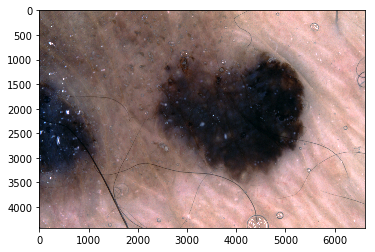

In [11]:
#resized pictures
temp = os.listdir(main_path+folder)
temp = [x for x in temp if ".jpg" in x]
img = Image.open(main_path+folder+"/"+temp[4])
plt.imshow(img)


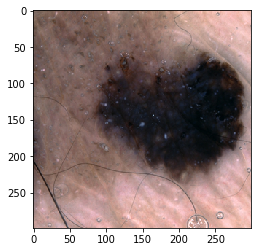

In [12]:
temp = os.listdir(main_path+folder)
temp = [x for x in temp if ".jpg" in x]
img = Image.open("../data/resized/"+temp[4])
plt.imshow(img)    

**Warning : ** resizing pictures deform images? except if padding

In [13]:
#control
target  = "../data/resized/"
filelist = [ f for f in os.listdir(target) if f.endswith(".jpg") ]

len(meta) == len(filelist)

NameError: name 'meta' is not defined

In [ ]:
print(len(meta))
print(len(filelist))

# III. Split into train and test